In [1]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 516.2MB 20kB/s 


In [1]:
import sys
sys.path.insert(1, '../FeatureEngineering')

import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dropout, Input
import matplotlib.pyplot as plt
from util import plot_history
import util
import feature_builder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-07-23 00:30:52--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.185.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.185.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  93.9MB/s    in 17s     

2020-07-23 00:31:08 (95.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [4]:
!mkdir -p './data/'
!mkdir -p './data/embeddings/'
!mv '/root/input/GoogleNews-vectors-negative300.bin.gz' './data/embeddings/word2vec.bin.gz'
!gzip -f -d  './data/embeddings/word2vec.bin.gz'

Cargo datasets

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Armo features con el feature_builder

In [6]:
def prepare_for_cnn(df):
    processed = feature_builder.process_dataset(
        df,
        encoding_type='binary',
        text_type='embeddings',
        use_manual_features=False,
        use_spacy=True,
        remove_target=False
    )
    to_numpy = processed.to_numpy()
    to_numpy = to_numpy.reshape(processed.shape[0], processed.shape[1], 1)
    return processed, to_numpy

In [7]:
%%time
processed, train = prepare_for_cnn(train_df)
train_target = train_df['target'].values

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Embeddings loaded!
Percentage of words covered in the embeddings = 0.4937444933920705
Embeddings loaded!
Percentage of words covered in the embeddings = 0.5879980378263476
CPU times: user 2min 3s, sys: 8.26 s, total: 2min 11s
Wall time: 3min 3s


In [8]:
processed

,spacy_text_embedding_0,spacy_text_embedding_1,spacy_text_embedding_2,spacy_text_embedding_3,spacy_text_embedding_4,spacy_text_embedding_5,spacy_text_embedding_6,spacy_text_embedding_7,spacy_text_embedding_8,spacy_text_embedding_9,spacy_text_embedding_10,spacy_text_embedding_11,spacy_text_embedding_12,spacy_text_embedding_13,spacy_text_embedding_14,spacy_text_embedding_15,spacy_text_embedding_16,spacy_text_embedding_17,spacy_text_embedding_18,spacy_text_embedding_19,spacy_text_embedding_20,spacy_text_embedding_21,spacy_text_embedding_22,spacy_text_embedding_23,spacy_text_embedding_24,spacy_text_embedding_25,spacy_text_embedding_26,spacy_text_embedding_27,spacy_text_embedding_28,spacy_text_embedding_29,spacy_text_embedding_30,spacy_text_embedding_31,spacy_text_embedding_32,spacy_text_embedding_33,spacy_text_embedding_34,spacy_text_embedding_35,spacy_text_embedding_36,spacy_text_embedding_37,spacy_text_embedding_38,spacy_text_embedding_39,...,text_embedding_269,text_embedding_270,text_embedding_271,text_embedding_272,text_embedding_273,text_embedding_274,text_embedding_275,text_embedding_276,text_embedding_277,text_embedding_278,text_embedding_279,text_embedding_280,text_embedding_281,text_embedding_282,text_embedding_283,text_embedding_284,text_embedding_285,text_embedding_286,text_embedding_287,text_embedding_288,text_embedding_289,text_embedding_290,text_embedding_291,text_embedding_292,text_embedding_293,text_embedding_294,text_embedding_295,text_embedding_296,text_embedding_297,text_embedding_298,text_embedding_299,target,c0,c1,c2,c3,c4,c5,c6,c7
0,0.157756,0.075226,0.187012,0.126872,-0.039958,0.071513,0.184001,-0.030090,0.252848,0.202311,-0.126139,-0.078776,-0.102783,0.167201,-0.101929,0.170166,0.086273,0.132487,-0.047813,-0.164876,0.082113,0.040365,0.204508,-0.058777,0.092539,-0.099365,-0.005697,-0.021255,-0.075419,-0.152588,-0.119832,0.003092,-0.191345,0.033518,0.011902,0.084693,0.098267,0.007365,0.065969,0.110524,...,-0.082419,-0.006305,0.091158,0.089337,0.071646,0.023024,-0.004038,-0.053260,-0.056171,-0.036896,-0.020282,-0.002176,-0.048902,0.033992,0.022123,0.045668,0.048753,-0.023968,-0.021759,0.005221,0.062214,-0.061016,0.070108,-0.074162,-0.037983,-0.022320,0.044012,-0.006672,-0.035675,0.017123,0.039420,1,0,0,0,0,0,0,0,0
1,0.055664,0.024200,-0.009262,0.085653,0.135091,0.004150,0.015259,-0.083923,-0.040029,0.008097,-0.050618,-0.161947,-0.096659,-0.150228,-0.094076,0.047078,0.046143,0.103638,0.013997,0.063243,-0.063639,-0.063761,0.025736,-0.005737,-0.048503,-0.000814,-0.133484,0.114258,0.110840,-0.033686,-0.000631,-0.032389,-0.127035,-0.036397,-0.147298,-0.072222,-0.079020,0.015869,0.077718,-0.076721,...,-0.024275,-0.115723,-0.009626,0.013149,-0.028460,0.050502,-0.027649,-0.006522,-0.071289,-0.029890,0.075126,-0.028390,0.036601,0.045358,0.008161,0.034302,-0.075439,-0.034180,-0.004429,0.055804,0.041085,-0.042480,-0.013410,-0.029018,0.119376,0.048235,0.007708,-0.099470,-0.030239,0.050014,0.039224,1,0,0,0,0,0,0,0,0
2,0.000875,0.013479,0.084412,-0.038966,-0.056183,-0.086884,0.025266,-0.009633,0.074320,0.000315,0.101649,-0.055514,0.041061,0.011576,-0.082886,0.038859,0.021540,-0.064921,-0.060135,0.040222,0.091464,-0.000519,0.036387,-0.109487,-0.026703,-0.088786,-0.088496,-0.023717,0.016032,-0.106893,0.017782,-0.065239,-0.146871,-0.065806,-0.053507,-0.069419,0.071350,-0.104126,-0.087636,0.020784,...,-0.004862,0.084084,0.089023,0.062089,0.056577,0.038343,-0.037138,-0.024242,-0.079453,-0.001676,-0.022888,0.035958,-0.032432,0.012626,0.065202,0.068505,0.051081,-0.078979,-0.008990,0.103253,0.047157,-0.094272,-0.043712,-0.072432,0.010154,0.075838,0.053999,-0.054176,-0.020408,0.018609,-0.027804,1,0,0,0,0,0,0,0,0
3,0.172323,-0.095561,0.014506,0.212870,0.025777,-0.078011,-0.059733,-0.028809,0.003270,0.085978,0.059041,-0.156087,-0.026917,0.027181,-0.054036,0.142354,-0.096415,0.040039,-0.085805,0.094482,0.011897,0.044149,0.075338,-0.099040,-0.091680,-0.085734,-0.009054,-0.032471,-0.015406,-0.080892,0.066711,-0.096619,-0.257650,-0.131393

Creo el modelo y corro la CNN

In [9]:
def create_model(X_train, filters, kernel_sizes, pool_sizes, units, cnn_layers, dense_layers):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
    for i in range(cnn_layers):
        model.add(Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], activation='relu'))
    model.add(MaxPooling1D(2))#pool_sizes[i]))

    model.add(Flatten())
    
    for i in range(dense_layers):
        model.add(Dense(units[i], activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])
    return model

In [24]:
filters=[32,32,64]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[64]
cnn_layers=3
dense_layers=1

In [25]:
filters=[64]
kernel_size=[3]
pool_sizes=[2]
units=[32]
cnn_layers=1
dense_layers=1

In [26]:
#acc = 0.8
filters=[128,128]
kernel_size=[3,3,3]
pool_sizes=[2,2,2]
units=[32, 32]
cnn_layers=2
dense_layers=2

In [10]:
#acc = 0.80 cleaner
filters=[128,128,128]
kernel_size=[3,4,5]
pool_sizes=[2,2,2]
units=[64,64,64]
cnn_layers=3
dense_layers=3

In [11]:
train = processed
def encode(x):
  return x.to_numpy().reshape(x.shape[0], x.shape[1], 1)


Fold 0

Epoch 1/15
159/159 [==============================] - 76s 480ms/step - loss: 0.6235 - accuracy: 0.6382 - val_loss: 0.4864 - val_accuracy: 0.8010
Epoch 2/15
159/159 [==============================] - 76s 476ms/step - loss: 0.4881 - accuracy: 0.7838 - val_loss: 0.4419 - val_accuracy: 0.8128
Epoch 3/15
159/159 [==============================] - 76s 476ms/step - loss: 0.4637 - accuracy: 0.7980 - val_loss: 0.4251 - val_accuracy: 0.8128
Epoch 4/15
159/159 [==============================] - 76s 479ms/step - loss: 0.4391 - accuracy: 0.8118 - val_loss: 0.4493 - val_accuracy: 0.8065
Epoch 5/15
159/159 [==============================] - 75s 474ms/step - loss: 0.4239 - accuracy: 0.8177 - val_loss: 0.4155 - val_accuracy: 0.8188
Epoch 6/15
159/159 [==============================] - 75s 472ms/step - loss: 0.4129 - accuracy: 0.8284 - val_loss: 0.4159 - val_accuracy: 0.8172
Epoch 7/15
159/159 [==============================] - 75s 474ms/step - loss: 0.3986 - accuracy: 0.8321 - val_loss: 0.4292

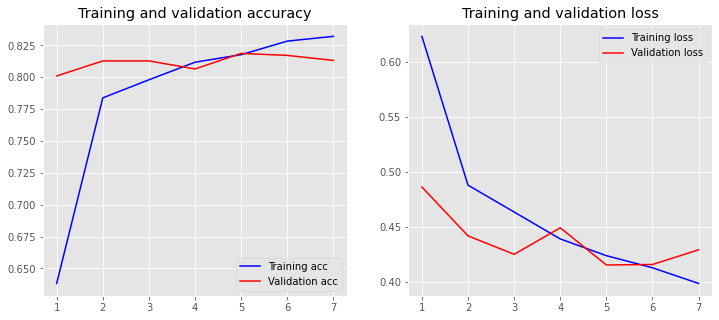

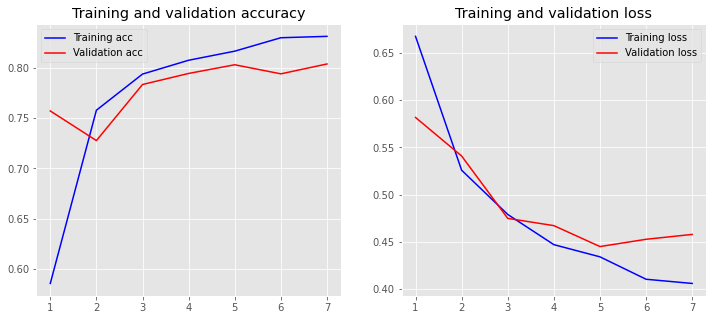

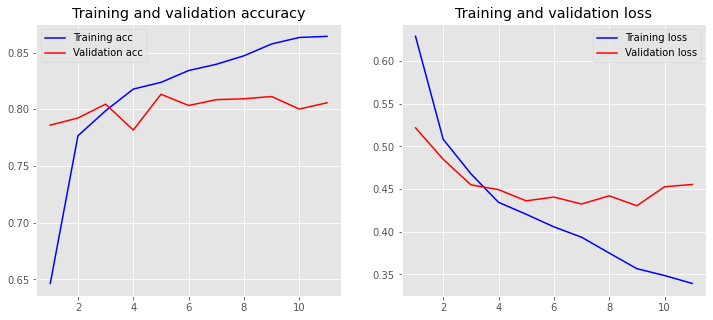

In [13]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
models = []
for fold, (trn_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    
    print('\nFold {}\n'.format(fold))
    X_train = encode(train.loc[trn_idx, :].drop(['target'], axis=1))
    y_train = train_df.loc[trn_idx, 'target']
    X_pred = encode(train.loc[val_idx, :].drop(['target'], axis=1))
    y_pred = train_df.loc[val_idx, 'target']

    model = create_model(
        X_train,
        filters=filters,
        kernel_sizes=kernel_size,
        pool_sizes=pool_sizes,
        units=units,
        cnn_layers=cnn_layers,
        dense_layers=dense_layers
    )
    es = keras.callbacks.EarlyStopping(patience=2)
    history = model.fit(X_train, y_train, epochs=15, validation_data=(X_pred, y_pred), callbacks=[es], batch_size=32)
    plot_history(history)
    models.append(model)

In [18]:
processed, X_test = prepare_for_cnn(test_df)

Embeddings loaded!
Percentage of words covered in the embeddings = 0.5707598689343111
Embeddings loaded!
Percentage of words covered in the embeddings = 0.6603057058767683


In [20]:
def predict(X):
  y_pred = np.zeros((X.shape[0], 1))

  for model in models:
      y_pred += model.predict(X_test) / len(models) 
  return y_pred

In [25]:
y_pred = predict(test_df)

final_df = pd.read_csv('sample_submission.csv')
final_df['target'] = np.round(y_pred).astype('int')
final_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [16]:
final_df['target'].value_counts()

0.0    1447
1.0    1090
Name: target, dtype: int64

In [24]:

final_df.to_csv('cnn_skf.csv', index=False)
from google.colab import files
files.download('cnn_skf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calculemos el test para kaggle

In [ ]:
prediction = model.predict_classes(X_pred)
f1 = f1_score(y_pred, [x[0] for x in prediction])
print(f'F1 Score: {f1}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
F1 Score: 0.769


In [ ]:
ids = test_df['id']

processed, final_test = prepare_for_cnn(test_df)
prediction = model.predict_classes(final_test)

final_df = pd.DataFrame({'target': [x[0] for x in prediction]}, index=ids)
final_df

Percentage of words covered in the embeddings = 0.5707598689343111
Percentage of words covered in the embeddings = 0.665389037945573


,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,0
10865,1
10868,1


In [ ]:
final_df['target'].value_counts()

0    2342
1     921
Name: target, dtype: int64

In [ ]:
final_df.count()

target    3263
dtype: int64

In [ ]:
final_df.to_csv('cnn_loc.csv')